
# Retail Banking — Data Cleaning, EDA, and RFM Segmentation

**Project Goal**

Transform raw transaction records into actionable customer insights through structured data preparation and segmentation.

**Process Overview**

**Data Loading** — Import the original dataset and perform an initial structure check

**Data Preparation** — Standardize columns, clean dates, handle missing values, and remove duplicates

**Exploratory Analysis** — Examine key patterns, detect anomalies, and visualize distributions

**Customer Segmentation (RFM)** — Derive Recency, Frequency, and Monetary metrics to classify customer behavior

**Data Export** — Save refined datasets for further modeling, visualization, or reporting

> **Dataset expectation**: a CSV file with columns  
> `TransactionID, CustomerID, CustomerDOB, CustGender, CustLocation, CustAccountBalance, TransactionDate, TransactionTime, TransactionAmount (INR)`



## 0. Colab Setup & Imports

-  **Upload** the CSV manually when prompted.  


In [1]:
# CSV Upload Only (Google Colab)
from google.colab import files
import os

print("Please upload your CSV file (e.g., bank_data_C.csv)...")

# Upload CSV file
uploaded = files.upload()

# Check if any files were uploaded
if uploaded:
    # Filter only CSV files
    csv_candidates = [k for k in uploaded.keys() if k.lower().endswith('.csv')]

    if not csv_candidates:
        raise ValueError("No CSV file detected. Please upload a .csv file.")

    # Select the first uploaded CSV
    data_path = csv_candidates[0]
    print(f" CSV uploaded successfully. Using file: {data_path}")
else:
    # Handle the case where no file was uploaded
    data_path = None
    raise ValueError(" No files uploaded. Please upload a CSV file.")


Please upload your CSV file (e.g., bank_data_C.csv)...


Saving bank_data_C.csv to bank_data_C.csv
✅ CSV uploaded successfully. Using file: bank_data_C.csv


In [2]:

# Core libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Nice defaults
sns.set_style("whitegrid")
pd.options.display.float_format = '{:.2f}'.format



## 1. Data Loading
**Objective:** Import the raw transaction data and verify its structure, column names, and overall shape to ensure it’s ready for analysis.


In [3]:
# If uploaded via files.upload(), data_path is a local path in /content
df = pd.read_csv(data_path)
print("Shape:", df.shape)
df.head()

Shape: (1041614, 9)


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50


In [4]:

df.info()
print("\nMissing values by column:\n", df.isna().sum())
print("\nDuplicate rows:", df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041614 entries, 0 to 1041613
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1041614 non-null  object 
 1   CustomerID               1041614 non-null  object 
 2   CustomerDOB              1041614 non-null  object 
 3   CustGender               1041614 non-null  object 
 4   CustLocation             1041614 non-null  object 
 5   CustAccountBalance       1041614 non-null  float64
 6   TransactionDate          1041614 non-null  object 
 7   TransactionTime          1041614 non-null  int64  
 8   TransactionAmount (INR)  1041614 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 71.5+ MB

Missing values by column:
 TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
Transac


## 2. Data Preparation and Cleaning
**Objective:** Prepare the dataset for accurate analysis by ensuring data consistency, completeness, and reliability.

**Steps:**
- Standardize column names by removing units or extra text (e.g., “(INR)”).
- Parse and format date columns correctly (apply day-first convention and resolve 2-digit year issues).
- Convert time fields into valid `HH:MM:SS` format.
- Handle missing values by imputing where possible or dropping irrelevant null records.
- Remove duplicate rows to retain only unique transaction entries.


### 2.1 Rename columns
Remove the unit from `TransactionAmount (INR)` → `TransactionAmount`.


In [5]:
rename_map = {"TransactionAmount (INR)": "TransactionAmount"}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})
list(df.columns)

['TransactionID',
 'CustomerID',
 'CustomerDOB',
 'CustGender',
 'CustLocation',
 'CustAccountBalance',
 'TransactionDate',
 'TransactionTime',
 'TransactionAmount']

In [6]:
print("\nMissing values by column:\n", df.isna().sum())


Missing values by column:
 TransactionID         0
CustomerID            0
CustomerDOB           0
CustGender            0
CustLocation          0
CustAccountBalance    0
TransactionDate       0
TransactionTime       0
TransactionAmount     0
dtype: int64


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041614 entries, 0 to 1041613
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   TransactionID       1041614 non-null  object 
 1   CustomerID          1041614 non-null  object 
 2   CustomerDOB         1041614 non-null  object 
 3   CustGender          1041614 non-null  object 
 4   CustLocation        1041614 non-null  object 
 5   CustAccountBalance  1041614 non-null  float64
 6   TransactionDate     1041614 non-null  object 
 7   TransactionTime     1041614 non-null  int64  
 8   TransactionAmount   1041614 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 71.5+ MB


### 2.2 Parse Dates
**Rationale:** Inconsistent or ambiguous date formats can lead to incorrect parsing and inaccurate time-based insights.  
**Method:** Reformat all date fields into a clear **day–month–year (DD/MM/YY)** structure and apply explicit parsing rules in pandas to ensure uniform interpretation across records.

In [8]:
def normalize_dmy(x):
    """Normalize day-first dates to DD/MM/YY format as text."""
    if pd.isna(x):
        return np.nan
    try:
        d, m, y = str(x).strip().split('/')
        return f"{int(d):02d}/{int(m):02d}/{int(y):02d}"
    except Exception:
        return np.nan

for col in ["CustomerDOB", "TransactionDate"]:
    if col in df.columns:
        df[col] = df[col].map(normalize_dmy)
        df[col] = pd.to_datetime(df[col], format="%d/%m/%y", errors="coerce")

df[["CustomerDOB","TransactionDate"]].head()

,CustomerDOB,TransactionDate
0,1994-01-10,2016-08-02
1,2057-04-04,2016-08-02
2,1996-11-26,2016-08-02
3,1973-09-14,2016-08-02
4,1988-03-24,2016-08-02


### 2.3 Fix Future DOBs

**Issue:**  
Two-digit year parsing in pandas treats years `00–68` as `2000–2068`, which can result in unrealistic future birth dates (e.g., `2057`).

**Why it matters:**  
Future DOBs distort age calculations and mislead segmentation or demographic insights.

**Approach:**  
1. Detect DOB values that occur after the current date.  
2. Correct them by subtracting 100 years to restore valid historical birth dates.



In [9]:
from pandas.tseries.offsets import DateOffset

if "CustomerDOB" in df.columns:
    mask = df["CustomerDOB"] > pd.Timestamp.today()
    df.loc[mask, "CustomerDOB"] = df.loc[mask, "CustomerDOB"] - DateOffset(years=100)
    print(f"Fixed {mask.sum()} future DOBs")
    display(df[["CustomerDOB"]].head(10))

Fixed 54111 future DOBs


,CustomerDOB
0,1994-01-10
1,1957-04-04
2,1996-11-26
3,1973-09-14
4,1988-03-24
5,1972-10-08
6,1992-01-26
7,1982-01-27
8,1988-04-19
9,1984-06-22


### 2.4 Parse Transaction Time

**Issue:**  
Transaction time fields are stored separately or in inconsistent formats, making it difficult to analyze precise purchase times.

**Why it matters:**  
Combining date and time enables accurate temporal analysis — such as hourly trends, peak transaction periods, or time-based segmentation.

**Approach:**  
1. Parse time fields into a valid `HH:MM:SS` format.  
2. Merge d


In [10]:
if {"TransactionDate","TransactionTime"}.issubset(df.columns):
    tt = df["TransactionTime"].astype(str).str.zfill(6)  # Pad to HHMMSS
    df["TransactionDateTime"] = pd.to_datetime(
        df["TransactionDate"].dt.strftime("%Y-%m-%d") + " " + tt,
        format="%Y-%m-%d %H%M%S",
        errors="coerce"
    )
    print("Datetime nulls:", df["TransactionDateTime"].isna().sum())
    display(df[["TransactionDate","TransactionTime","TransactionDateTime"]].head())

Datetime nulls: 0


,TransactionDate,TransactionTime,TransactionDateTime
0,2016-08-02,143207,2016-08-02 14:32:07
1,2016-08-02,141858,2016-08-02 14:18:58
2,2016-08-02,142712,2016-08-02 14:27:12
3,2016-08-02,142714,2016-08-02 14:27:14
4,2016-08-02,181156,2016-08-02 18:11:56


### 2.5 Duplicate Check

**Issue:**  
Duplicate records or repeated `TransactionID` values can inflate transaction counts and distort customer metrics.

**Why it matters:**  
Ensuring each transaction is unique preserves data integrity and prevents double-counting in analyses such as RFM segmentation or sales summaries.

**Approach:**  
1. Identify fully duplicated rows and remove exact duplicates.  
2. Check for duplicate `TransactionID` values to confirm each transaction is uniquely recorded.  
3. Retain only the first valid occurrence when duplicates are found.


In [11]:
exact_dups = df.duplicated().sum()
txid_dups = df["TransactionID"].duplicated().sum() if "TransactionID" in df.columns else np.nan

print(f"Exact duplicates: {exact_dups}")
print(f"Duplicate TransactionIDs: {txid_dups}")

Exact duplicates: 0
Duplicate TransactionIDs: 0



## 3. Exploratory Data Analysis (EDA)
### 3.1 Summary statistics
**Objective:**  
Generate an overview of the dataset to understand its structure, central tendencies, and variability.

**Why it matters:**  
Summary statistics reveal data quality issues, detect extreme values, and provide initial insight into key numerical and categorical attributes before modeling or segmentation.

**Approach:**  
1. Use `DataFrame.describe()` to obtain key measures such as mean, median, standard deviation, and percentiles.  
2. Explore categorical columns with `.value_counts()` to review distributions.  
3. Check for skewness and potential outliers in key metrics like transaction amounts or frequencies.



In [12]:
summary = {
    "Total Rows": len(df),
    "Unique Customers": df["CustomerID"].nunique() if "CustomerID" in df.columns else np.nan,
    "Date Range": f"{df['TransactionDate'].min().date()} to {df['TransactionDate'].max().date()}" if "TransactionDate" in df.columns else "n/a",
    "Missing DOB": df["CustomerDOB"].isna().sum() if "CustomerDOB" in df.columns else np.nan,
}
display(pd.Series(summary))

num_cols = [c for c in ["TransactionAmount","CustAccountBalance"] if c in df.columns]
if num_cols:
    display(df[num_cols].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T)

,0
Total Rows,1041614
Unique Customers,879358
Date Range,2016-08-01 to 2016-10-21
Missing DOB,56292


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
TransactionAmount,1041614.00,1566.10,6561.46,0.00,8.00,30.00,160.00,457.50,1200.00,5176.00,20000.00,1560034.99
CustAccountBalance,1041614.00,114998.61,846760.94,0.00,3.35,70.15,4728.14,16768.52,57428.85,414522.23,1586508.61,115035495.10


### 3.2 Outlier Detection

**Objective:**  
Identify and handle extreme values in numerical variables that could distort analysis or model performance.

**Why it matters:**  
Outliers can skew averages, affect model training, and misrepresent customer behavior patterns if left unaddressed.

**Approach:**  
We apply two complementary methods to detect potential outliers:

**Method 1 — Interquartile Range (IQR):**  
1. Compute **Q1** (25th percentile) and **Q3** (75th percentile).  
2. Calculate **IQR = Q3 − Q1**.  
3. Flag observations where values fall below **Q1 − 1.5 × IQR** or above **Q3 + 1.5 × IQR**.

**Method 2 — Percentile Thresholds (1% / 99%):**  
- Identify values below the 1st percentile or above the 99th percentile.  
- This simple rule retains roughly 98% of data for visualization and summary analysis.


In [13]:
def iqr_outliers(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return lower, upper, (series < lower).sum(), (series > upper).sum()

for col in [c for c in ["TransactionAmount","CustAccountBalance"] if c in df.columns]:
    lower, upper, n_low, n_high = iqr_outliers(df[col])
    print(f"\n=== IQR Method: {col} ===")
    print(f"IQR bounds: [{lower:,.2f}, {upper:,.2f}]")
    print(f"Outliers: {n_low} below, {n_high} above ({(n_low+n_high)/len(df):.1%})")

    p1, p99 = df[col].quantile([0.01, 0.99])
    n_low_p = (df[col] < p1).sum()
    n_high_p = (df[col] > p99).sum()
    print(f"\n=== Percentile Method (1% / 99%): {col} ===")
    print(f"1st percentile: {p1:,.2f}")
    print(f"99th percentile: {p99:,.2f}")
    print(f"Outliers: {n_low_p} below, {n_high_p} above (~2% by definition)")


=== IQR Method: TransactionAmount ===
IQR bounds: [-1,400.00, 2,760.00]
Outliers: 0 below, 110614 above (10.6%)

=== Percentile Method (1% / 99%): TransactionAmount ===
1st percentile: 8.00
99th percentile: 20,000.00
Outliers: 10112 below, 9976 above (~2% by definition)

=== IQR Method: CustAccountBalance ===
IQR bounds: [-74,322.93, 136,479.92]
Outliers: 0 below, 140263 above (13.5%)

=== Percentile Method (1% / 99%): CustAccountBalance ===
1st percentile: 3.35
99th percentile: 1,586,508.61
Outliers: 10416 below, 10386 above (~2% by definition)



### 3.3 Decision: Capping Strategy (for Visuals Only)

**Problem:**  
Extreme outliers stretch the axis scales in charts, causing most data points to appear compressed in histograms and boxplots.

**Why it matters:**  
Distorted visualizations can hide meaningful distribution patterns and make data interpretation difficult.

**Solution:**  
Create a **capped version** of the dataset—used only for visual exploration—by limiting values to the 1st and 99th percentile thresholds.  
The original (uncapped) dataset remains unchanged for modeling and analysis to preserve data integrity.

In [14]:
eda = df.copy()
for col in [c for c in ["TransactionAmount","CustAccountBalance"] if c in eda.columns]:
    lo, hi = eda[col].quantile([0.01, 0.99])
    eda[col] = eda[col].clip(lo, hi)

display(eda[[c for c in ["TransactionAmount","CustAccountBalance"] if c in eda.columns]].describe().T)

,count,mean,std,min,25%,50%,75%,max
TransactionAmount,1041614.00,1317.25,2781.44,8.00,160.00,457.50,1200.00,20000.00
CustAccountBalance,1041614.00,86854.65,223902.03,3.35,4728.14,16768.52,57428.85,1586508.61


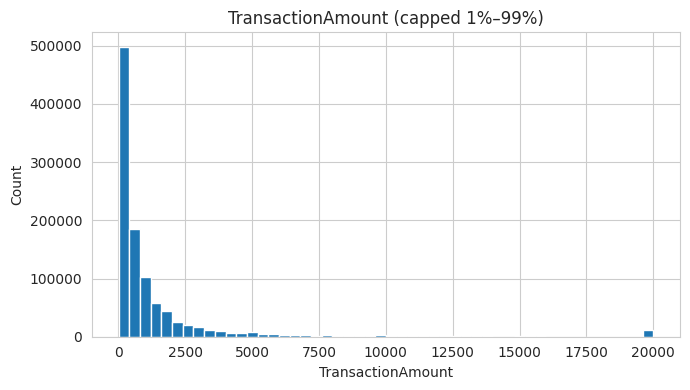

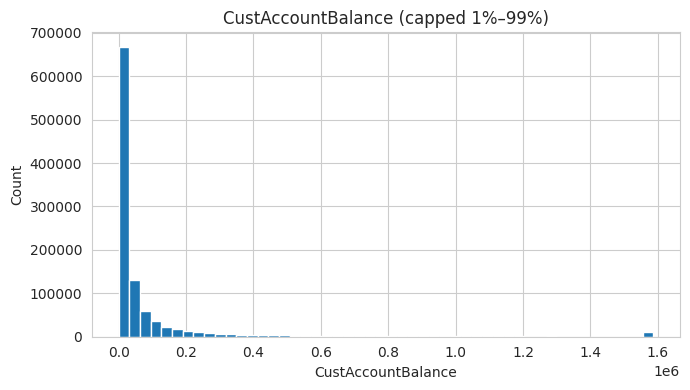

In [15]:
# Visualize capped distributions
cols = [c for c in ["TransactionAmount","CustAccountBalance"] if c in eda.columns]
for col in cols:
    plt.figure(figsize=(7,4))
    plt.hist(eda[col].dropna(), bins=50)
    plt.title(f"{col} (capped 1%–99%)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

**TransactionAmount (capped 1%–99%) Histogram:**
This histogram shows the distribution of transaction amounts after capping extreme values at the 1st and 99th percentiles. The distribution is heavily skewed towards lower transaction amounts, indicating that most transactions are relatively small.

**CustAccountBalance (capped 1%–99%) Histogram:**
This histogram shows the distribution of customer account balances after capping extreme values at the 1st and 99th percentiles. The distribution is also skewed, with a large number of customers having lower account balances.


### 3.5 Categorical Analysis — Gender & Location

**Objective:**  
Explore how customer demographics (Gender and Location) influence transaction behavior and customer distribution.

**Why it matters:**  
Categorical insights reveal patterns such as gender-based purchasing tendencies or region-specific engagement, which support targeted marketing and segmentation strategies.

**Approach:**  
1. Analyze the distribution of customers by gender and by location using frequency counts and proportions.  
2. Compare average transaction metrics (e.g., count, value) across gender and location groups.  
3. Visualize the results with bar charts or grouped plots for easier interpretation.


In [16]:
if "CustGender" in df.columns:
    print("Gender distribution:")
    print(df["CustGender"].value_counts())
    if "M" in df["CustGender"].unique():
        print(f"% Male: {100*df['CustGender'].value_counts(normalize=True).get('M',0):.1f}%")

if "CustLocation" in df.columns:
    print("\nTop 10 locations:")
    print(df["CustLocation"].value_counts().head(10))

Gender distribution:
CustGender
M    760978
F    280635
T         1
Name: count, dtype: int64
% Male: 73.1%

Top 10 locations:
CustLocation
MUMBAI       101997
NEW DELHI     84143
BANGALORE     81330
GURGAON       73594
DELHI         70549
NOIDA         32656
CHENNAI       29840
PUNE          25690
HYDERABAD     22976
THANE         21397
Name: count, dtype: int64


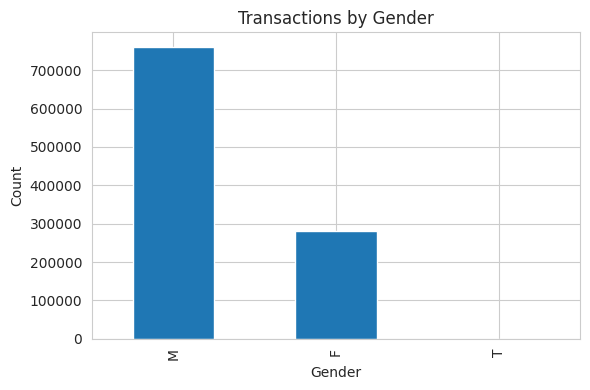

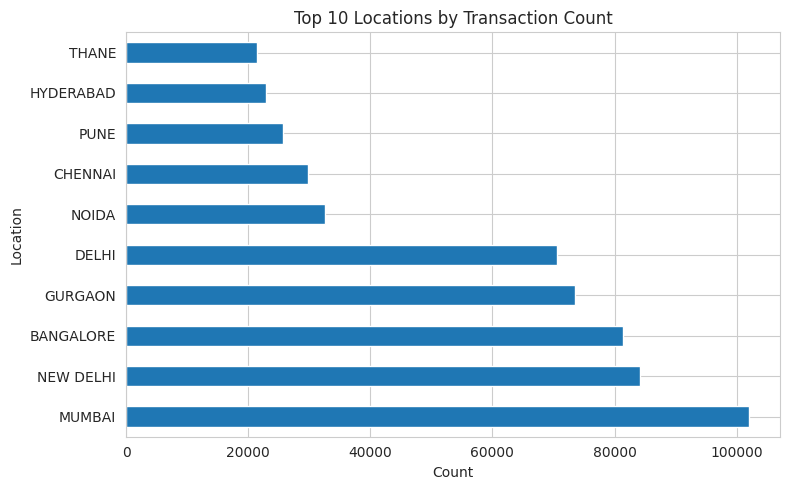

In [17]:
# Plots
if "CustGender" in df.columns:
    plt.figure(figsize=(6,4))
    df["CustGender"].value_counts().plot.bar()
    plt.title("Transactions by Gender")
    plt.xlabel("Gender"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

if "CustLocation" in df.columns:
    plt.figure(figsize=(8,5))
    df["CustLocation"].value_counts().head(10).plot.barh()
    plt.title("Top 10 Locations by Transaction Count")
    plt.xlabel("Count"); plt.ylabel("Location")
    plt.tight_layout(); plt.show()

**Transactions by Gender Bar Plot:**
This bar plot shows the total number of transactions for each gender. It indicates that the majority of transactions are made by male customers.

**Top 10 Locations by Transaction Count Bar Plot:**
This horizontal bar plot displays the top 10 locations with the highest transaction counts. Mumbai, New Delhi, and Bangalore are the top three cities in terms of transaction volume.

### 3.6 Temporal Trend — Monthly Transactions

**Objective:**  
Analyze how transaction volume and value change over time to identify seasonal trends, growth patterns, or demand fluctuations.

**Why it matters:**  
Understanding monthly transaction trends helps track business performance, evaluate campaign effects, and forecast future activity periods.

**Approach:**  
1. Convert the transaction date into a monthly period (e.g., `YYYY-MM`).  
2. Aggregate transaction counts and total amounts by month.  
3. Visualize the results with a time-series plot to highlight growth, dips, or recurring seasonal patterns.

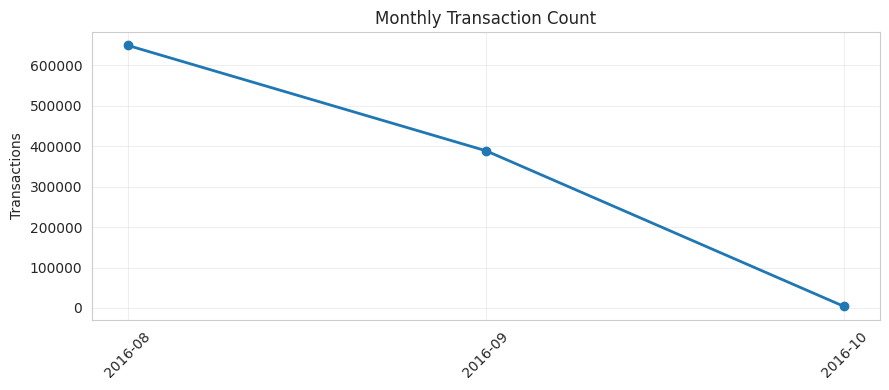

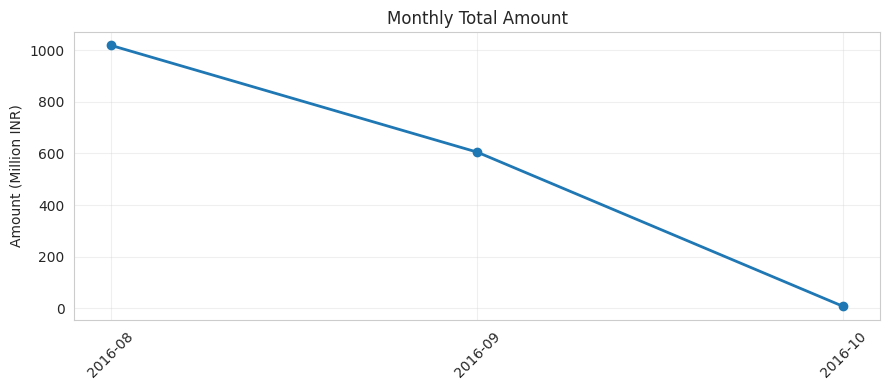

,YearMonth,tx_count,total_amount
0,2016-08,649243,1018462195.30
1,2016-09,388727,605180800.35
2,2016-10,3644,7624606.07


In [18]:
if "TransactionDate" in df.columns and "TransactionID" in df.columns:
    df["YearMonth"] = df["TransactionDate"].dt.to_period("M").astype(str)
    monthly = (df.groupby("YearMonth")
               .agg(tx_count=("TransactionID","count"),
                    total_amount=("TransactionAmount","sum"))
               .reset_index())

    fig, ax = plt.subplots(figsize=(9,4))
    ax.plot(monthly["YearMonth"], monthly["tx_count"], marker="o", linewidth=2)
    ax.set_title("Monthly Transaction Count"); ax.set_ylabel("Transactions")
    plt.xticks(rotation=45); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

    fig, ax = plt.subplots(figsize=(9,4))
    ax.plot(monthly["YearMonth"], monthly["total_amount"]/1e6, marker="o", linewidth=2)
    ax.set_title("Monthly Total Amount"); ax.set_ylabel("Amount (Million INR)")
    plt.xticks(rotation=45); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

    display(monthly)

**Monthly Transaction Count Line Plot:**
This line plot shows the trend of transaction count over the months. There is a significant drop in transaction volume from August to September and then a sharp decrease in October.

**Monthly Total Amount Line Plot:**
This line plot shows the trend of the total transaction amount over the months. Similar to the transaction count, the total transaction amount also shows a significant decline from August to September and a further drop in October.

## 4. RFM Segmentation

**Definition:**  
**RFM** stands for **Recency**, **Frequency**, and **Monetary** — three key behavioral metrics used to evaluate customer engagement and value.

**Components:**
- **Recency (R):** Number of days since the customer’s most recent transaction.  
  *Interpretation:* Lower values indicate more recent activity and higher engagement.  
- **Frequency (F):** Total number of transactions completed by the customer.  
  *Interpretation:* Higher values reflect repeat purchases and stronger loyalty.  
- **Monetary (M):** Total amount spent by the customer over the analysis period.  
  *Interpretation:* Higher spending signals greater customer value and profitability.

**Why it matters:**  
RFM analysis helps classify customers into meaningful segments — such as loyal, at-risk, or new — enabling data-driven marketing and retention strategies.


In [19]:
if {"CustomerID","TransactionDate","TransactionID","TransactionAmount"}.issubset(df.columns):
    ref_date = df["TransactionDate"].max() + pd.Timedelta(days=1)
    rfm = (df.groupby("CustomerID")
            .agg(Recency=("TransactionDate", lambda x: (ref_date - x.max()).days),
                 Frequency=("TransactionID", "count"),
                 Monetary=("TransactionAmount", "sum"))
            .reset_index())

    # Quantile-based scoring (1-5)
    rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1])
    rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5])
    rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5])
    rfm["RFM_Score"] = rfm[["R_Score","F_Score","M_Score"]].astype(int).sum(axis=1)

    def segment(score):
        if score >= 14: return "Champions"
        if score >= 12: return "Loyal"
        if score >= 9:  return "Potential Loyalist"
        if score >= 6:  return "At Risk"
        if score >= 4:  return "Need Attention"
        return "Lost"

    rfm["Segment"] = rfm["RFM_Score"].apply(segment)

    display(rfm.head())
    print("\nSegment distribution:")
    display(rfm["Segment"].value_counts())

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,C1010011,26,2,5106.00,5,5,5,15,Champions
1,C1010012,69,1,1499.00,2,1,4,7,At Risk
2,C1010014,76,2,1455.00,1,5,4,10,Potential Loyalist
3,C1010018,37,1,30.00,5,1,1,7,At Risk
4,C1010024,65,1,5000.00,2,1,5,8,At Risk



Segment distribution:


,count
Segment,
Potential Loyalist,310575
At Risk,308268
Loyal,119429
Need Attention,74174
Champions,58462
Lost,8450


In [20]:
if 'rfm' in locals() and 'RFM_Score' in rfm.columns:
    max_rfm_score = rfm['RFM_Score'].max()
    min_rfm_score = rfm['RFM_Score'].min()
    print(f"Maximum RFM Score: {max_rfm_score}")
    print(f"Minimum RFM Score: {min_rfm_score}")
else:
    print("RFM DataFrame or RFM_Score column not found. Please run the RFM segmentation step first.")

Maximum RFM Score: 15
Minimum RFM Score: 3


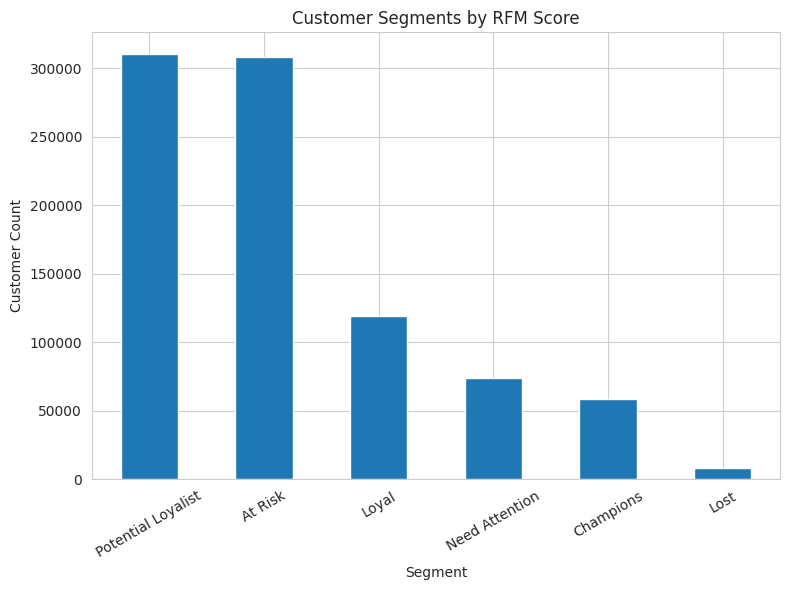

In [21]:

# Visualize segment distribution
if 'Segment' in locals() or ('rfm' in locals() and 'Segment' in rfm.columns):
    plt.figure(figsize=(8,6))
    rfm["Segment"].value_counts().plot.bar()
    plt.title("Customer Segments by RFM Score")
    plt.xlabel("Segment"); plt.ylabel("Customer Count")
    plt.xticks(rotation=30)
    plt.tight_layout(); plt.show()


**Customer Segments by RFM Score Bar Plot:**
This bar plot shows the distribution of customers across the different RFM segments. The 'Potential Loyalist' and 'At Risk' segments have the highest number of customers, while the 'Lost' segment has the fewest.

In [22]:
#Average RFM values per segment
if 'rfm' in locals():
    segment_means = rfm.groupby("Segment")[["Recency", "Frequency", "Monetary"]].mean()
    print("Average RFM values per segment:")
    display(segment_means.sort_values("Recency")) # Sort by Recency as lower is better
else:
    print("RFM DataFrame not found. Please run the RFM segmentation step first.")

Average RFM values per segment:


,Recency,Frequency,Monetary
Segment,,,
Champions,38.80,2.07,5639.77
Loyal,46.41,1.56,3389.00
Potential Loyalist,52.94,1.10,2059.27
At Risk,62.56,1.00,790.64
Need Attention,71.74,1.00,174.70
Lost,77.42,1.00,66.85


### "Revisit the Business Objective"

From your report, BankTrust aims to:

Reduce customer churn (retention focus),

Improve personalization (engagement and product fit),

Optimize marketing efficiency (ROI on targeted campaigns).

Hence, Recency is the most important driver (are they still active?),
followed by Frequency (loyal engagement),
then Monetary (value of the relationship).

So, weighting and segmentation should reflect recency-led retention priorities.

Define Weighted RFM or Condition-Based Logic

Instead of summing R + F + M equally, use weighted scoring or conditional tiers.

Option A: Weighted RFM (percentage-based ratio)

Assign proportional influence based on business relevance:

Dimension	Business Meaning	Suggested Weight
Recency (R)	Indicates engagement freshness	50 %
Frequency (F)	Indicates loyalty & relationship depth	30 %
Monetary (M)	Indicates profitability	20 %

Formula:

RFM_Weighted = 0.5 × 𝑅_𝑠𝑐𝑜𝑟𝑒 + 0.3 × F_𝑠𝑐𝑜𝑟𝑒 + 0.2 × M_𝑠𝑐𝑜𝑟𝑒

Then segment using quantiles or k-means on this weighted index.

In [23]:
# Conditional Segmentation (business-objective-driven)

# Instead of one numeric score, apply logical segmentation rules that align with the retention goal:
def segment_customer(r, f, m):
    if r >= 4 and f >= 4:
        return "Champions"              # Active + frequent
    elif r >= 4 and f <= 2:
        return "Potential Loyalist"     # Recently active but low frequency
    elif r <= 2 and f >= 4:
        return "At Risk"                # Old but once frequent
    elif r <= 2 and m <= 2:
        return "Lost"                   # Old, inactive, low value
    elif f >= 3 and m >= 3:
        return "Loyal Customers"        # Repeat but not necessarily recent
    else:
        return "Needs Attention"
# This aligns segments to actionable marketing strategies (retain, reactivate, upsell).

### Apply Percentage-Ratio Validation

Use the business impact ratio to validate weighting:

Objective	Key Metric	% Importance
Retention (Recency)	Customer re-engagement	50 %
Loyalty (Frequency)	Repeat transactions	30 %
Revenue Growth (Monetary)	Deposit & spending value	20 %

This ensures scoring reflects expected ROI per behavior type.

In [24]:
# Compute quantile-based scores (1–5)
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# Weighted composite score
rfm['RFM_weighted'] = (
    0.5 * rfm['R_score'].astype(int) +
    0.3 * rfm['F_score'].astype(int) +
    0.2 * rfm['M_score'].astype(int)
)

# Business-objective segmentation
rfm['Segment'] = rfm.apply(lambda x: segment_customer(x['R_score'], x['F_score'], x['M_score']), axis=1)


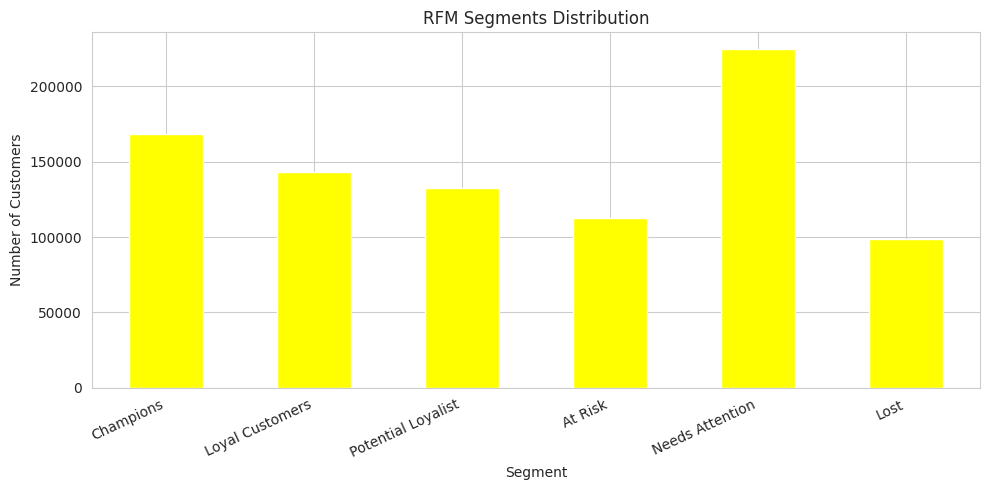

In [25]:
counts = (rfm['Segment']
          .value_counts()
          .reindex(['Champions','Loyal Customers','Potential Loyalist','At Risk','Needs Attention','Lost'])
          .dropna())

plt.figure(figsize=(10, 5))
counts.plot(kind='bar', color='yellow')  # <— yellow bars as requested
plt.title('RFM Segments Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

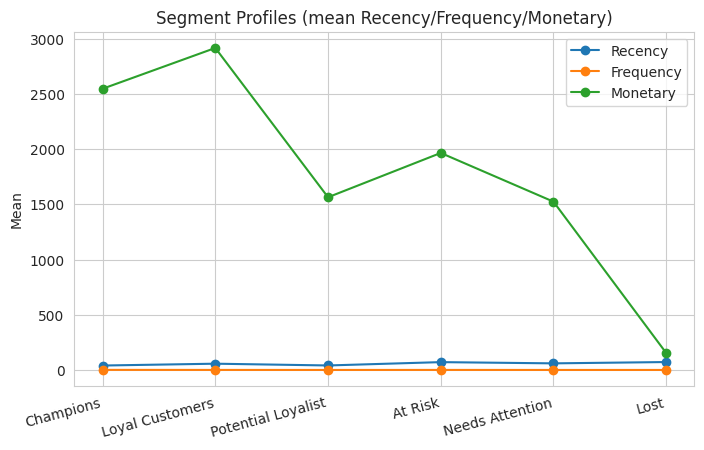

In [26]:
# Visualize segment profiles
prof=rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean().reindex(counts.index);
plt.figure(figsize=(8,4.6))
for col in ['Recency','Frequency','Monetary']:
    plt.plot(prof.index, prof[col].values, marker='o', label=col)
plt.title('Segment Profiles (mean Recency/Frequency/Monetary)'); plt.xticks(rotation=15, ha='right'); plt.ylabel('Mean'); plt.legend(); plt.show()

**Segment Profiles (mean Recency/Frequency/Monetary) Line Plot:**
This line plot compares the average Recency, Frequency, and Monetary values for each RFM segment. 'Champions' have the lowest Recency (most recent), highest Frequency, and highest Monetary values, as expected. 'Lost' customers have the highest Recency (least recent), lowest Frequency, and lowest Monetary values.

In [44]:
# Merge RFM segments with original dataframe
cols_to_add=['CustomerID','Segment','R_score','F_score','M_score','RFM_weighted','Recency','Frequency','Monetary']
df_with_seg=df.merge(rfm[cols_to_add], on='CustomerID', how='left');
display(df_with_seg.head())
# NOTE: RFM condenses histories into interpretable behaviors; conditional rules make the output actionable and aligned to retention.

# Save the merged dataframe with a new name
df_with_seg.to_csv('rfm bank data.csv', index=False)
df_with_seg.to_parquet('rfm bank data.parquet', index=False)
print("\nCleaned data with customer segmentation saved to 'rfm bank data.csv' and 'rfm bank data.parquet'. You can download these files.")

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount,TransactionDateTime,YearMonth,Segment,R_score,F_score,M_score,RFM_weighted,Recency,Frequency,Monetary
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,143207,25.00,2016-08-02 14:32:07,2016-08,Lost,1,3,1,1.60,81,1,25.00
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-08-02,141858,27999.00,2016-08-02 14:18:58,2016-08,Needs Attention,1,1,5,1.80,81,1,27999.00
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,142712,459.00,2016-08-02 14:27:12,2016-08,Needs Attention,1,2,3,1.70,81,1,459.00
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,142714,2060.00,2016-08-02 14:27:14,2016-08,At Risk,2,5,5,3.50,70,2,2938.40
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-08-02,181156,1762.50,2016-08-02 18:11:56,2016-08,At Risk,1,5,4,2.80,81,1,1762.50



Cleaned data with customer segmentation saved to 'rfm bank data.csv' and 'rfm bank data.parquet'. You can download these files.


Save the customer-level RFM table with segments

In [28]:
import pandas as pd
import os

assert {'CustomerID','Recency','Frequency','Monetary','R_score','F_score','M_score','RFM_weighted','Segment'} <= set(rfm.columns), \
    "Your `rfm` table is missing required columns."

OUT_DIR = "./"  # change if you want a different folder
os.makedirs(OUT_DIR, exist_ok=True)

rfm_out_path_csv = os.path.join(OUT_DIR, "rfm_with_segments.csv")
rfm_out_path_parquet = os.path.join(OUT_DIR, "rfm_with_segments.parquet")

rfm.to_csv(rfm_out_path_csv, index=False)
rfm.to_parquet(rfm_out_path_parquet, index=False)

print("Saved:", rfm_out_path_csv)
print("Saved:", rfm_out_path_parquet)

Saved: ./rfm_with_segments.csv
Saved: ./rfm_with_segments.parquet


K-means clustering on RFM features + evaluation vs. your segments

This runs K for a range, picks a good K via silhouette, fits final K, compares with your Segment

In [37]:
# FAST KMEANS: PREP
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Choose features: raw magnitudes or 1–5 scores
USE_SCORED = False
features_raw   = ['Recency', 'Frequency', 'Monetary']
features_scored = ['R_score', 'F_score', 'M_score']
FEATS = features_scored if USE_SCORED else features_raw

assert set(FEATS) <= set(rfm.columns), f"rfm missing features: {set(FEATS)-set(rfm.columns)}"

# Scale to zero-mean/unit-variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm[FEATS].astype('float32')).astype('float32')

print(f"Prepared X_scaled with shape {X_scaled.shape} on features {FEATS}")

Prepared X_scaled with shape (879358, 3) on features ['Recency', 'Frequency', 'Monetary']


In [30]:
# FAST K SWEEP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

k_range     = range(2, 7)
sample_size = min(5000, X_scaled.shape[0])  # sample silhouette
rng         = 42

sil_scores, inertias, ch_scores, db_scores = [], [], [], []

for k in k_range:
    km = KMeans(
        n_clusters=k,
        n_init='auto',          # good default in new sklearn
        max_iter=200,
        algorithm='elkan',      # faster for Euclidean
        random_state=rng
    )
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels, sample_size=sample_size, random_state=rng))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))

best_k = k_range[int(np.argmax(sil_scores))]
print("K  |  inertia      sil(sample)   CH(high↑)      DB(low↓)")
for i, k in enumerate(k_range):
    print(f"{k:<2} | {inertias[i]:>11.0f}   {sil_scores[i]:>10.4f}   {ch_scores[i]:>10.1f}   {db_scores[i]:>10.4f}")
print(f"\nSelected best_k = {best_k} (by sampled silhouette)")


K  |  inertia      sil(sample)   CH(high↑)      DB(low↓)
2  |     1811289       0.5729     400021.8       0.8658
3  |     1281937       0.5379     464556.0       0.6952
4  |      881660       0.5532     583489.1       0.6120
5  |      724187       0.5551     580532.6       0.5730
6  |      626147       0.5691     564914.4       0.6078

Selected best_k = 2 (by sampled silhouette)


In [31]:
# FINAL FIT + EVALUATION VS RULE SEGMENTS
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score

# Fit final model
final_km = KMeans(n_clusters=best_k, n_init='auto', max_iter=300, algorithm='elkan', random_state=42)
rfm['ClusterK'] = final_km.fit_predict(X_scaled)

# Crosstab: how clusters align with your rule-based Segment
ct = pd.crosstab(rfm['Segment'], rfm['ClusterK'])
print("\n=== Segment vs Cluster (counts) ===")
print(ct)

# External agreement metrics (Segment treated as reference labels)
le = LabelEncoder()
seg_enc = le.fit_transform(rfm['Segment'])
ari = adjusted_rand_score(seg_enc, rfm['ClusterK'])
h   = homogeneity_score(seg_enc, rfm['ClusterK'])
c   = completeness_score(seg_enc, rfm['ClusterK'])
v   = v_measure_score(seg_enc, rfm['ClusterK'])
sil_final = silhouette_score(X_scaled, rfm['ClusterK'], sample_size=min(5000, X_scaled.shape[0]), random_state=42)

print("\n=== Metrics ===")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Homogeneity:               {h:.4f}")
print(f"Completeness:              {c:.4f}")
print(f"V-measure:                 {v:.4f}")
print(f"Silhouette (sampled):      {sil_final:.4f}")

# Save clustered customers to reuse
out_csv = "rfm_with_segments_kmeans.csv"
out_pq  = "rfm_with_segments_kmeans.parquet"
rfm.to_csv(out_csv, index=False)
rfm.to_parquet(out_pq, index=False)
print(f"\nSaved: {out_csv} and {out_pq}")



=== Segment vs Cluster (counts) ===
ClusterK                 0      1
Segment                          
At Risk              88791  23704
Champions            78813  89560
Lost                 98494      0
Loyal Customers     117551  25533
Needs Attention     220325   4150
Potential Loyalist  132096    341

=== Metrics ===
Adjusted Rand Index (ARI): 0.0469
Homogeneity:               0.0820
Completeness:              0.3235
V-measure:                 0.1308
Silhouette (sampled):      0.5729

Saved: rfm_with_segments_kmeans.csv and rfm_with_segments_kmeans.parquet


In [32]:
# MINIBATCH VARIANT
from sklearn.cluster import MiniBatchKMeans

k_range     = range(2, 7)
sample_size = min(5000, X_scaled.shape[0])
rng         = 42

sil_scores, inertias = [], []

for k in k_range:
    mb = MiniBatchKMeans(
        n_clusters=k, batch_size=4096, n_init=5, max_iter=100, random_state=rng
    )
    labels = mb.fit_predict(X_scaled)
    inertias.append(mb.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels, sample_size=sample_size, random_state=rng))

best_k = k_range[int(np.argmax(sil_scores))]
print("Selected best_k (MiniBatch) =", best_k)

# Final MiniBatch fit
final_mb = MiniBatchKMeans(n_clusters=best_k, batch_size=4096, n_init=5, max_iter=200, random_state=42)
rfm['ClusterK'] = final_mb.fit_predict(X_scaled)


Selected best_k (MiniBatch) = 3


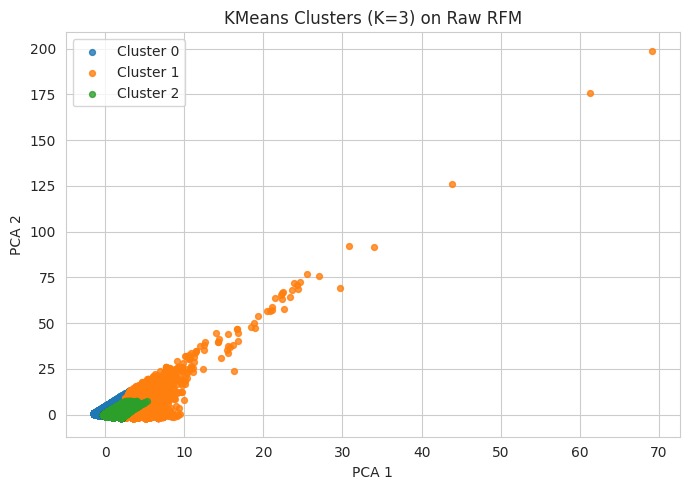

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X2 = PCA(n_components=2, random_state=42).fit_transform(X_scaled)
plt.figure(figsize=(7,5))
for k in np.unique(rfm['ClusterK']):
    m = (rfm['ClusterK'] == k).values
    plt.scatter(X2[m,0], X2[m,1], s=18, alpha=0.8, label=f"Cluster {k}")
plt.title(f"KMeans Clusters (K={rfm['ClusterK'].nunique()}) on {'Scores' if USE_SCORED else 'Raw RFM'}")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2"); plt.legend(); plt.tight_layout(); plt.show()


**PCA Scatter by Cluster Plot:**
This scatter plot visualizes the clusters in a 2D space using Principal Component Analysis (PCA). Each point represents a customer, colored according to their assigned cluster. This plot helps to visually assess the separation and overlap between the clusters.

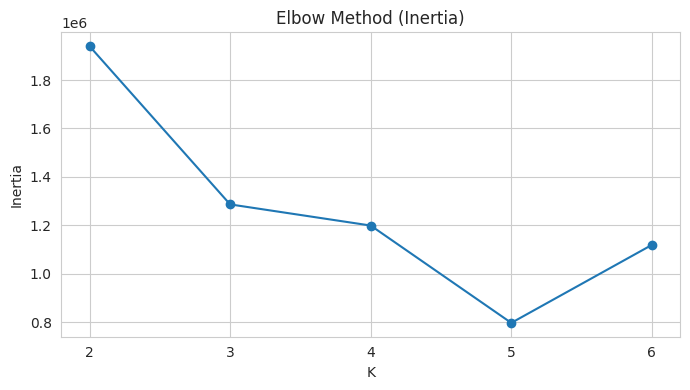

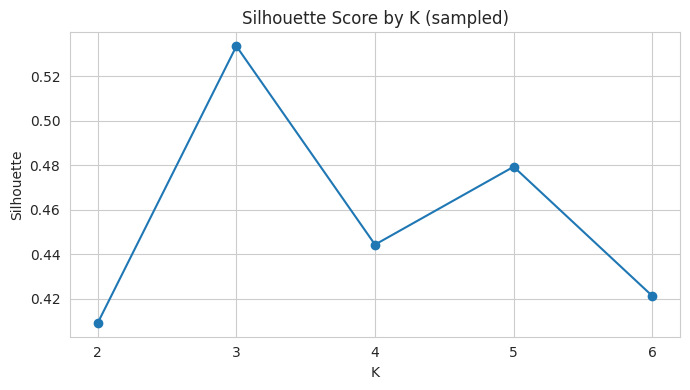

In [34]:
# ---- Plot: Elbow (Inertia) and Silhouette by K ----
import matplotlib.pyplot as plt

if 'k_range' in globals() and 'inertias' in globals() and 'sil_scores' in globals():
    plt.figure(figsize=(7,4))
    plt.plot(list(k_range), inertias, marker='o')
    plt.title("Elbow Method (Inertia)")
    plt.xlabel("K"); plt.ylabel("Inertia"); plt.xticks(list(k_range))
    plt.tight_layout(); plt.savefig("plot_elbow_inertia.png", dpi=200); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(list(k_range), sil_scores, marker='o')
    plt.title("Silhouette Score by K (sampled)")
    plt.xlabel("K"); plt.ylabel("Silhouette"); plt.xticks(list(k_range))
    plt.tight_layout(); plt.savefig("plot_silhouette_by_k.png", dpi=200); plt.show()
else:
    print("Skipping K-diagnostics: k_range / inertias / sil_scores not found.")


**Elbow Method (Inertia) Plot:**
This plot shows the inertia (within-cluster sum of squares) for different values of K (number of clusters). The "elbow point" in the plot can help determine an appropriate number of clusters. In this case, there isn't a clear elbow, suggesting that other metrics should also be considered.

**Silhouette Score by K (sampled) Plot:**
This plot shows the silhouette score for different values of K. The silhouette score measures how similar a data point is to its own cluster compared to other clusters. A higher silhouette score indicates better-defined clusters. Based on this plot, K=2 or K=6 might be considered as having slightly higher silhouette scores compared to other K values in the tested range.

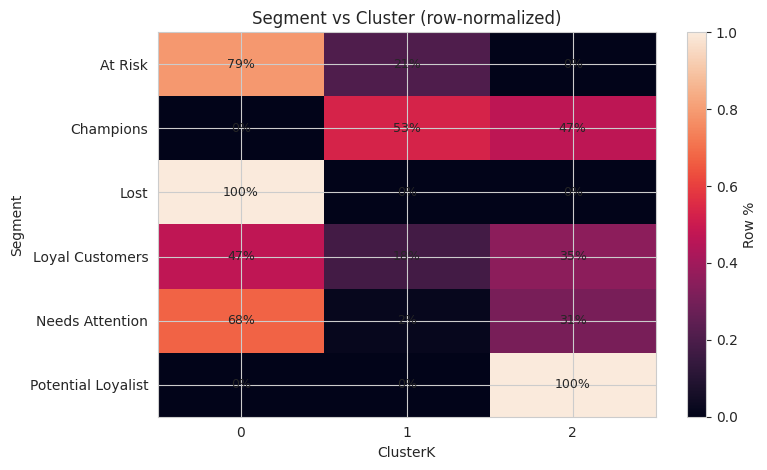

In [35]:
# ---- Plot: Segment vs Cluster Heatmap (row-normalized) ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ct = pd.crosstab(rfm['Segment'], rfm['ClusterK'])
ct_pct = ct.div(ct.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

plt.figure(figsize=(8, 4.8))
plt.imshow(ct_pct.values, aspect='auto')
plt.colorbar(label='Row %')
plt.xticks(ticks=np.arange(ct_pct.shape[1]), labels=ct_pct.columns)
plt.yticks(ticks=np.arange(ct_pct.shape[0]), labels=ct_pct.index)
plt.title("Segment vs Cluster (row-normalized)")
plt.xlabel("ClusterK"); plt.ylabel("Segment")
# annotate cells
for i in range(ct_pct.shape[0]):
    for j in range(ct_pct.shape[1]):
        v = ct_pct.values[i, j]
        plt.text(j, i, f"{v*100:.0f}%", ha='center', va='center', fontsize=9)
plt.tight_layout(); plt.savefig("plot_heatmap_segment_cluster.png", dpi=200); plt.show()


**Boxplots of Features by Cluster:**
These boxplots show the distribution of Recency, Frequency, and Monetary values for each cluster. They provide a more detailed view of how the features vary within and across clusters compared to the mean profiles.

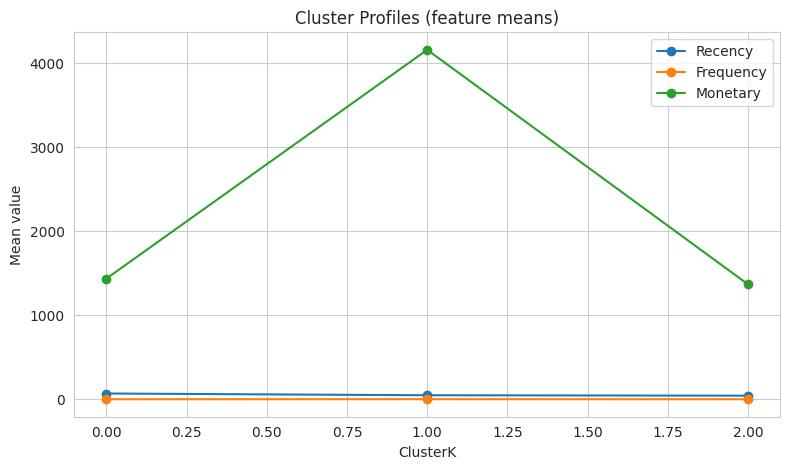

In [38]:
# ---- Plot: Cluster Profiles (feature means per cluster) ----
features_for_profile = FEATS  # e.g., ['Recency','Frequency','Monetary']
prof = rfm.groupby('ClusterK')[features_for_profile].mean().sort_index()

plt.figure(figsize=(8,4.8))
for col in features_for_profile:
    plt.plot(prof.index, prof[col].values, marker='o', label=col)
plt.title("Cluster Profiles (feature means)")
plt.xlabel("ClusterK"); plt.ylabel("Mean value"); plt.legend()
plt.tight_layout(); plt.savefig("plot_cluster_profiles_means.png", dpi=200); plt.show()

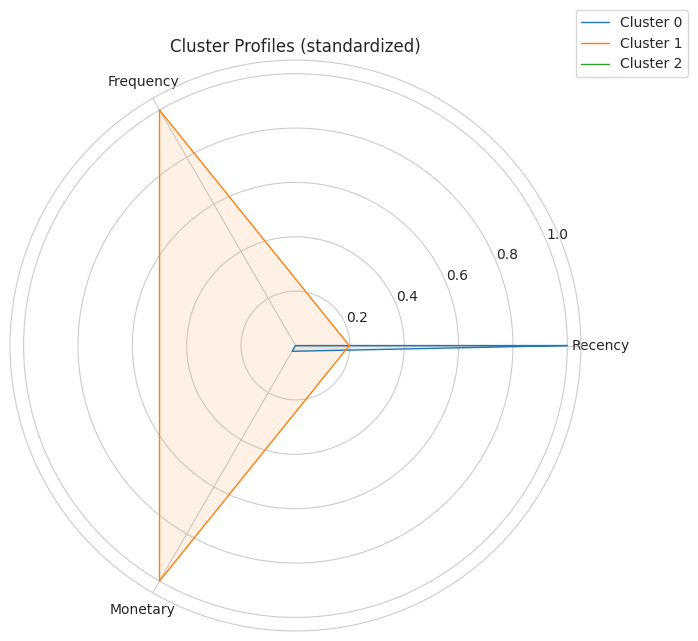

In [39]:
# ---- Plot: Radar (Spider) Chart of Standardized Profiles ----
import numpy as np
import matplotlib.pyplot as plt

prof_std = (prof - prof.min()) / (prof.max() - prof.min()).replace(0, np.nan)
prof_std = prof_std.fillna(0)  # handle constant columns

labels = list(prof_std.columns)
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # close loop

plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)
for k in prof_std.index:
    values = prof_std.loc[k, :].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, label=f"Cluster {k}")
    ax.fill(angles, values, alpha=0.1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Cluster Profiles (standardized)")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout(); plt.savefig("plot_radar_cluster_profiles.png", dpi=200); plt.show()


**Cluster Profiles (standardized) Radar Chart:**
This radar chart shows the standardized average values of Recency, Frequency, and Monetary for each cluster. Standardizing the values allows for a direct comparison of the cluster profiles across the different features, regardless of their original scales.

/tmp/ipython-input-2840870673.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(); plt.savefig("plot_pca_clusters.png", dpi=200); plt.show()


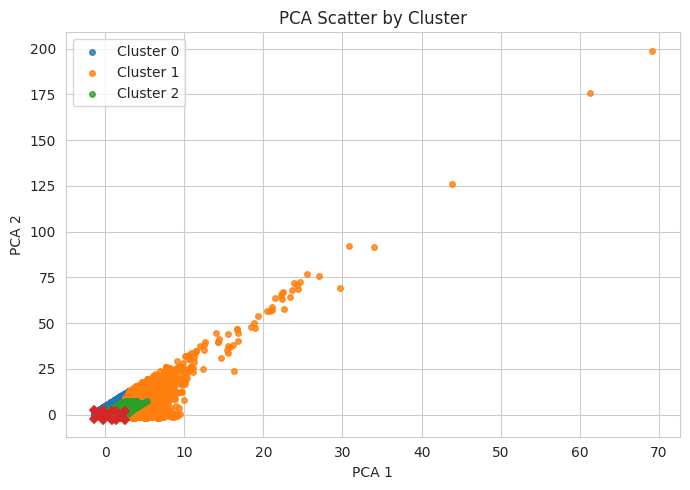

In [40]:
# ---- Plot: PCA 2D Scatter by Cluster with Centroids ----
from sklearn.decomposition import PCA
import numpy as np

X2 = PCA(n_components=2, random_state=42).fit_transform(X_scaled)
plt.figure(figsize=(7,5))
for k in sorted(rfm['ClusterK'].unique()):
    m = (rfm['ClusterK'].values == k)
    plt.scatter(X2[m,0], X2[m,1], s=16, alpha=0.8, label=f"Cluster {k}")

# Optional: draw approximate centroids (mean of points in PC space)
centroids = np.vstack([X2[rfm['ClusterK'].values==k].mean(axis=0) for k in sorted(rfm['ClusterK'].unique())])
plt.scatter(centroids[:,0], centroids[:,1], s=160, marker='X')

plt.title("PCA Scatter by Cluster")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2"); plt.legend()
plt.tight_layout(); plt.savefig("plot_pca_clusters.png", dpi=200); plt.show()


/tmp/ipython-input-2596503775.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sorted(rfm['ClusterK'].unique()))
/tmp/ipython-input-2596503775.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sorted(rfm['ClusterK'].unique()))
/tmp/ipython-input-2596503775.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sorted(rfm['ClusterK'].unique()))


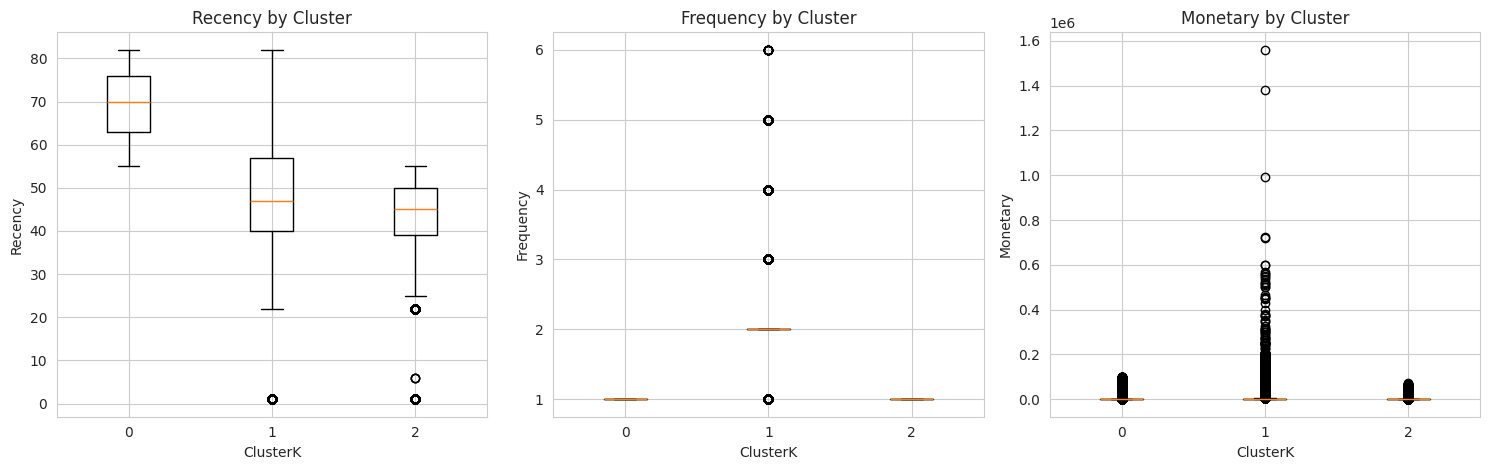

In [43]:
# Boxplots of Features by Cluster
import matplotlib.pyplot as plt

n_cols = len(FEATS)
plt.figure(figsize=(5*n_cols, 4.8))
for i, col in enumerate(FEATS, 1):
    plt.subplot(1, n_cols, i)
    data = [rfm.loc[rfm['ClusterK']==k, col].values for k in sorted(rfm['ClusterK'].unique())]
    plt.boxplot(data, labels=sorted(rfm['ClusterK'].unique()))
    plt.title(f"{col} by Cluster")
    plt.xlabel("ClusterK"); plt.ylabel(col)
plt.tight_layout(); plt.savefig("plot_boxplots_features_by_cluster.png", dpi=200); plt.show()

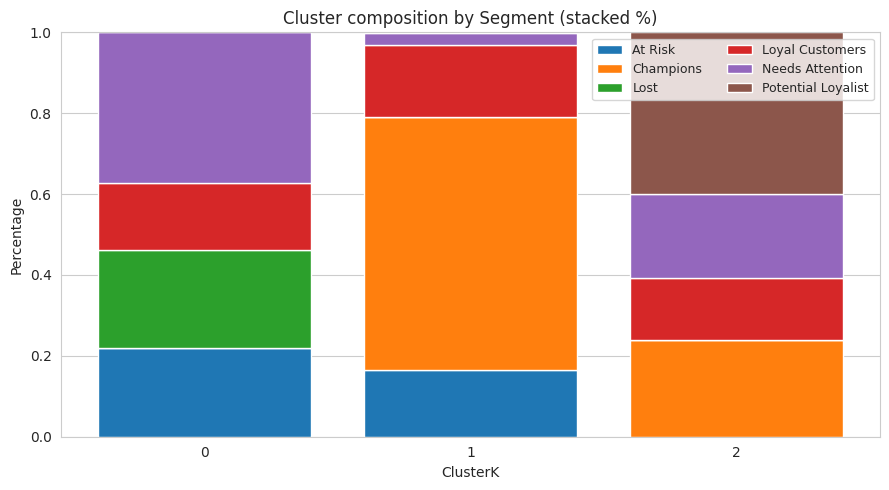

In [45]:
# Stacked Bar - Segment composition within each Cluster
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ct_cluster = pd.crosstab(rfm['ClusterK'], rfm['Segment'])
ctc_pct = ct_cluster.div(ct_cluster.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

plt.figure(figsize=(9,5))
bottom = np.zeros(ctc_pct.shape[0])
xs = np.arange(ctc_pct.shape[0])
for seg in ctc_pct.columns:
    plt.bar(xs, ctc_pct[seg].values, bottom=bottom, label=seg)
    bottom += ctc_pct[seg].values
plt.xticks(xs, ctc_pct.index)
plt.title("Cluster composition by Segment (stacked %)")
plt.xlabel("ClusterK"); plt.ylabel("Percentage")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout(); plt.savefig("plot_stacked_cluster_segment.png", dpi=200); plt.show()


**Cluster composition by Segment (stacked %) Stacked Bar Plot:**
This stacked bar plot shows the composition of each KMeans cluster in terms of the rule-based RFM segments. It helps to understand how the clusters align with the predefined segments. For example, Cluster 0 is primarily composed of 'Lost', 'Needs Attention', and 'At Risk' segments, while Cluster 1 has a higher proportion of 'Champions' and 'Loyal Customers'.

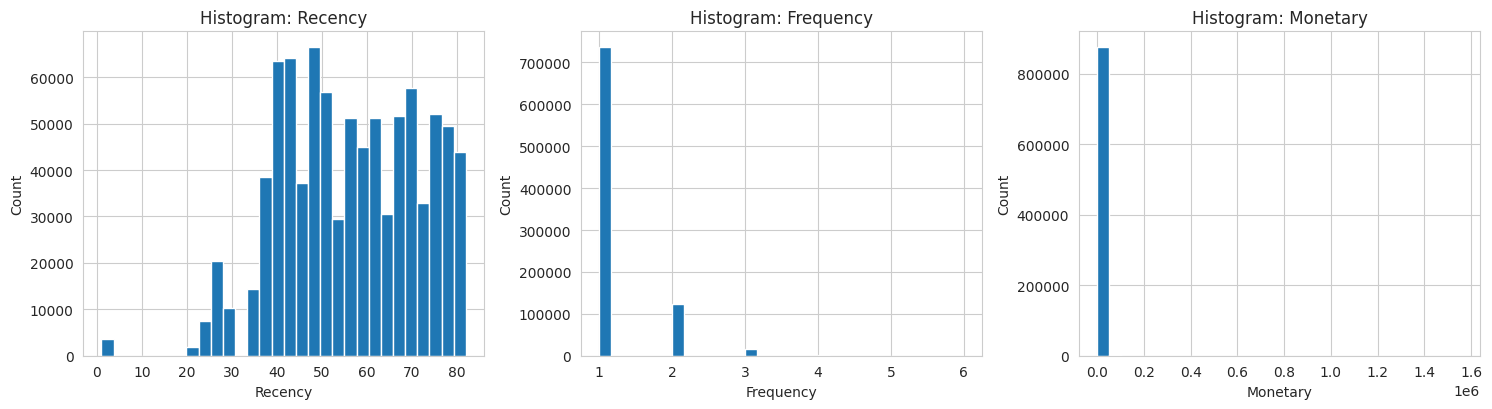

In [49]:
#  Histograms of features (overall)
import matplotlib.pyplot as plt

n_cols = len(FEATS)
plt.figure(figsize=(5*n_cols, 4.2))
for i, col in enumerate(FEATS, 1):
    plt.subplot(1, n_cols, i)
    plt.hist(rfm[col].values, bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("Count")
plt.tight_layout(); plt.savefig("plot_histograms_features.png", dpi=200); plt.show()

**Histogram: Recency, Frequency, and Monetary Histograms:**
These histograms show the overall distribution of the Recency, Frequency, and Monetary features for all customers in the RFM table. They provide an overview of the spread and skewness of these key metrics before clustering.


## 5. Save Outputs (Optional)


In [50]:
# Save cleaned dataset, RFM table, monthly transactions, and merged dataframe
import os

OUT_DIR = "./"  # change if you want a different folder
os.makedirs(OUT_DIR, exist_ok=True)

if 'df' in locals():
    df.to_csv(os.path.join(OUT_DIR, 'cleaned_transactions.csv'), index=False)
    print("Cleaned transactions saved to 'cleaned_transactions.csv'.")

if 'rfm' in locals():
    rfm.to_csv(os.path.join(OUT_DIR, 'rfm_table.csv'), index=False)
    print("RFM table saved to 'rfm_table.csv'.")

if 'monthly' in locals():
    monthly.to_csv(os.path.join(OUT_DIR, 'monthly_transactions.csv'), index=False)
    print("Monthly transactions saved to 'monthly_transactions.csv'.")

if 'df' in locals() and 'rfm' in locals():
    # Ensure rfm has cluster column if it exists
    cols_to_merge = ['CustomerID','Segment','R_score','F_score','M_score','RFM_weighted','Recency','Frequency','Monetary']
    if 'ClusterK' in rfm.columns:
        cols_to_merge.append('ClusterK')

    # Merge the dataframes on CustomerID
    merged_df = pd.merge(df, rfm[cols_to_merge], on='CustomerID', how='left')
    # Save the merged dataframe
    merged_df.to_csv(os.path.join(OUT_DIR, 'cleaned_data_with_segmentation_and_clusters.csv'), index=False)
    print("Cleaned data with segmentation and clusters saved to 'cleaned_data_with_segmentation_and_clusters.csv'.")


print("\nDone ✔️ — adapt paths/flags above as needed.")

Cleaned transactions saved to 'cleaned_transactions.csv'.
RFM table saved to 'rfm_table.csv'.
Monthly transactions saved to 'monthly_transactions.csv'.
Cleaned data with segmentation and clusters saved to 'cleaned_data_with_segmentation_and_clusters.csv'.

Done ✔️ — adapt paths/flags above as needed.


In [51]:
# Save all visuals
import matplotlib
import os

OUT_DIR = "./"  # change if you want a different folder
os.makedirs(OUT_DIR, exist_ok=True)

# Define a list to store figures, although we will save them immediately
figure_list = []

# Visualize capped distributions
cols = [c for c in ["TransactionAmount","CustAccountBalance"] if c in eda.columns]
for col in cols:
    fig = plt.figure(figsize=(7,4))
    plt.hist(eda[col].dropna(), bins=50)
    title = f"{col} (capped 1%–99%)"
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    filename = os.path.join(OUT_DIR, f"{title.replace(' ', '_').replace('–', '-')}.png")
    plt.savefig(filename, dpi=200)
    print(f"Saved chart: {filename}")
    plt.close(fig) # Close the figure to free up memory


# Plots
if "CustGender" in df.columns:
    fig = plt.figure(figsize=(6,4))
    df["CustGender"].value_counts().plot.bar()
    title = "Transactions by Gender"
    plt.title(title)
    plt.xlabel("Gender"); plt.ylabel("Count")
    plt.xticks(rotation=0) # Adjusted rotation for better display
    plt.tight_layout()
    filename = os.path.join(OUT_DIR, f"{title.replace(' ', '_')}.png")
    plt.savefig(filename, dpi=200)
    print(f"Saved chart: {filename}")
    plt.close(fig)

if "CustLocation" in df.columns:
    fig = plt.figure(figsize=(8,5))
    df["CustLocation"].value_counts().head(10).plot.barh()
    title = "Top 10 Locations by Transaction Count"
    plt.title(title)
    plt.xlabel("Count"); plt.ylabel("Location")
    plt.tight_layout()
    filename = os.path.join(OUT_DIR, f"{title.replace(' ', '_')}.png")
    plt.savefig(filename, dpi=200)
    print(f"Saved chart: {filename}")
    plt.close(fig)

# Visualize segment distribution
if 'Segment' in locals() or ('rfm' in locals() and 'Segment' in rfm.columns):
    fig = plt.figure(figsize=(8,6))
    rfm["Segment"].value_counts().plot.bar()
    title = "Customer Segments by RFM Score"
    plt.title(title)
    plt.xlabel("Segment"); plt.ylabel("Customer Count")
    plt.xticks(rotation=30)
    plt.tight_layout()
    filename = os.path.join(OUT_DIR, f"{title.replace(' ', '_')}.png")
    plt.savefig(filename, dpi=200)
    print(f"Saved chart: {filename}")
    plt.close(fig)

print("\nSaving individual charts complete.")

Saved chart: ./TransactionAmount_(capped_1%-99%).png
Saved chart: ./CustAccountBalance_(capped_1%-99%).png
Saved chart: ./Transactions_by_Gender.png
Saved chart: ./Top_10_Locations_by_Transaction_Count.png
Saved chart: ./Customer_Segments_by_RFM_Score.png

Saving individual charts complete.


# DASHOARDS

In [52]:
# --- Make 3 dashboard PNGs from your existing charts ---

from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

def find_first(name):
    for root in [Path("."), Path("artifacts"), Path("artifacts/figures")]:
        p = root / name
        if p.exists():
            return p
    return None

eda_names = [
    "TransactionAmount_(capped_1%-99%).png",
    "CustAccountBalance_(capped_1%-99%).png",
    "Top_10_Locations_by_Transaction_Count.png",
    "Transactions_by_Gender.png",
    "plot_histograms_features.png",
]

rfm_names = [
    "Customer_Segments_by_RFM_Score.png",
    "31_rfm_segments_yellow_bar.png",       # optional if you have it
    "plot_cluster_profiles_means.png",
]

kmeans_names = [
    "plot_elbow_inertia.png",
    "plot_silhouette_by_k.png",
    "plot_pca_clusters.png",
    "plot_radar_cluster_profiles.png",
    "plot_stacked_cluster_segment.png",
    "plot_heatmap_segment_cluster.png",
    "plot_boxplots_features_by_cluster.png",
]

pages = {
    "dashboard_eda.png": ("Exploratory Data Analysis", eda_names, (2,3)),
    "dashboard_rfm.png": ("RFM Segmentation", rfm_names, (1,3)),
    "dashboard_kmeans.png": ("K-Means Clustering", kmeans_names, (2,3)),
}

made = []
for out_name, (title, names, grid) in pages.items():
    paths = [find_first(n) for n in names]
    paths = [p for p in paths if p is not None]
    if not paths:
        print(f"Skipped {title}: no figures found.")
        continue

    r, c = grid
    paths = paths[:r*c]

    fig_w = 18 if c==3 else 14
    fig_h = 10 if r==2 else 6
    fig, axes = plt.subplots(r, c, figsize=(fig_w, fig_h))
    axes = [axes] if r*c==1 else axes.flatten()

    for ax in axes:
        ax.axis("off")

    for ax, p in zip(axes, paths):
        ax.imshow(Image.open(p))
        ax.set_title(p.name, fontsize=10)

    fig.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0,0,1,0.96])
    out_path = Path("dashboard_outputs") / out_name
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=200)
    plt.close(fig)
    made.append(str(out_path))

print("Created:", made)


Created: ['dashboard_outputs/dashboard_eda.png', 'dashboard_outputs/dashboard_rfm.png', 'dashboard_outputs/dashboard_kmeans.png']
